## 1- importer les bibliothéques

In [3]:
import os
from PIL import Image
import numpy as np 
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import make_scorer, recall_score, precision_score

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation, BatchNormalization
from keras.backend import dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

## 2- fixer les path des données augmenter 

In [4]:
sj_path='/kaggle/input/sjdata/DATA_(512,512)/sj_data'
nsj_path='/kaggle/input/sjdata/DATA_(512,512)/nsj_data'

## Mise en Forme des images

In [5]:

def mise_tenseur (path, nl, nc,pl):
    images_liste = os.listdir(path)
    images_liste.sort()
    Nb_images = len(images_liste)
    tenseur = np.empty((Nb_images, nl, nc, pl), dtype=np.uint8)
    k = 0
    for im in images_liste:
       
        img = imread(path+'/'+im)
        tenseur[k, :, :, 0] = img
        k +=1
    return(tenseur)

In [6]:
sj_original=mise_tenseur(sj_path,512,512,1)
nsj_original=mise_tenseur(nsj_path,512,512,1)

In [7]:
# diviser la base en 2
nsj_org_data=nsj_original
sj_org_data=sj_original
label_nsj = [0] * len(nsj_org_data)  # labels pour la première classe (0)
label_sj = [1] * len(sj_org_data)  # labels pour la deuxième classe (1)
# Fusionner les données et les labels en un seul tableau multidimensionnel
data2 = np.concatenate([nsj_org_data, sj_org_data])
print(len(data2))
labels2 = np.concatenate([label_nsj, label_sj])
len(labels2)


225


225

In [8]:
x_train, x_test, y_train, y_test = train_test_split(data2, labels2, test_size=0.2, random_state=42)
# normaliser les données 
x_train = x_train.reshape(x_train.shape[0], 512,512, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 512,512, 1).astype('float32') / 255

# cnn

In [17]:
model = Sequential()
model.add(Conv2D(32,(11,11),activation='relu', input_shape = (512,512,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, kernel_size = (7,7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, kernel_size = (7,7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, kernel_size = (7,7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, kernel_size = (7,7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 502, 502, 32)      3904      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 251, 251, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 245, 245, 32)      50208     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 122, 122, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 116, 116, 32)      50208     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 58, 58, 32)      

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [19]:
import numpy as np
from sklearn.utils import resample


n_iterations = 1000
# Initialiser les listes pour stocker les mesures de performance
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
lrs_plus = []
lrs_moins = []

for _ in range(n_iterations):
    # Perform bootstrap resampling on the training data
    x_sample,y_sample = resample(x_train,y_train, n_samples=150, random_state=48)
    

    # Train the model on the bootstrap sample
    
    model.fit( x_sample,y_sample)
    #evaluer le modele 
    y_pred = model.predict(x_test)
    y_pred_classes = np.where(y_pred>0.5,1.,0)
    # calculer les métriques d'évaluation
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)

    # Calculez la sensibilité, la spécificité, le FPR et le FNR à partir de la matrice de confusion
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred_classes)
    TN, FP, FN, TP = cm.ravel()
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)

    # Calculez le LR+ et le LR- à partir de la sensibilité et de la spécificité
    lr_plus = sensitivity / (1 - specificity)
    lr_moins = (1 - sensitivity) / specificity
    
    # Stocker les mesures de performance pour l'itération actuelle
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1_score)
    lrs_plus.append(lr_plus)
    lrs_moins.append(lr_moins)

2/2 [==============================] - 0s 39ms/step


/tmp/ipykernel_32/1985348728.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  lr_plus = sensitivity / (1 - specificity)


2/2 [==============================] - 0s 44ms/step


/tmp/ipykernel_32/1985348728.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  lr_plus = sensitivity / (1 - specificity)


2/2 [==============================] - 0s 39ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_32/1985348728.py:40: RuntimeWarning: invalid value encountered in double_scalars
  lr_plus = sensitivity / (1 - specificity)


2/2 [==============================] - 0s 39ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_32/1985348728.py:40: RuntimeWarning: invalid value encountered in double_scalars
  lr_plus = sensitivity / (1 - specificity)


2/2 [==============================] - 0s 39ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_32/1985348728.py:40: RuntimeWarning: invalid value encountered in double_scalars
  lr_plus = sensitivity / (1 - specificity)


2/2 [==============================] - 0s 39ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_32/1985348728.py:40: RuntimeWarning: invalid value encountered in double_scalars
  lr_plus = sensitivity / (1 - specificity)


2/2 [==============================] - 0s 39ms/step


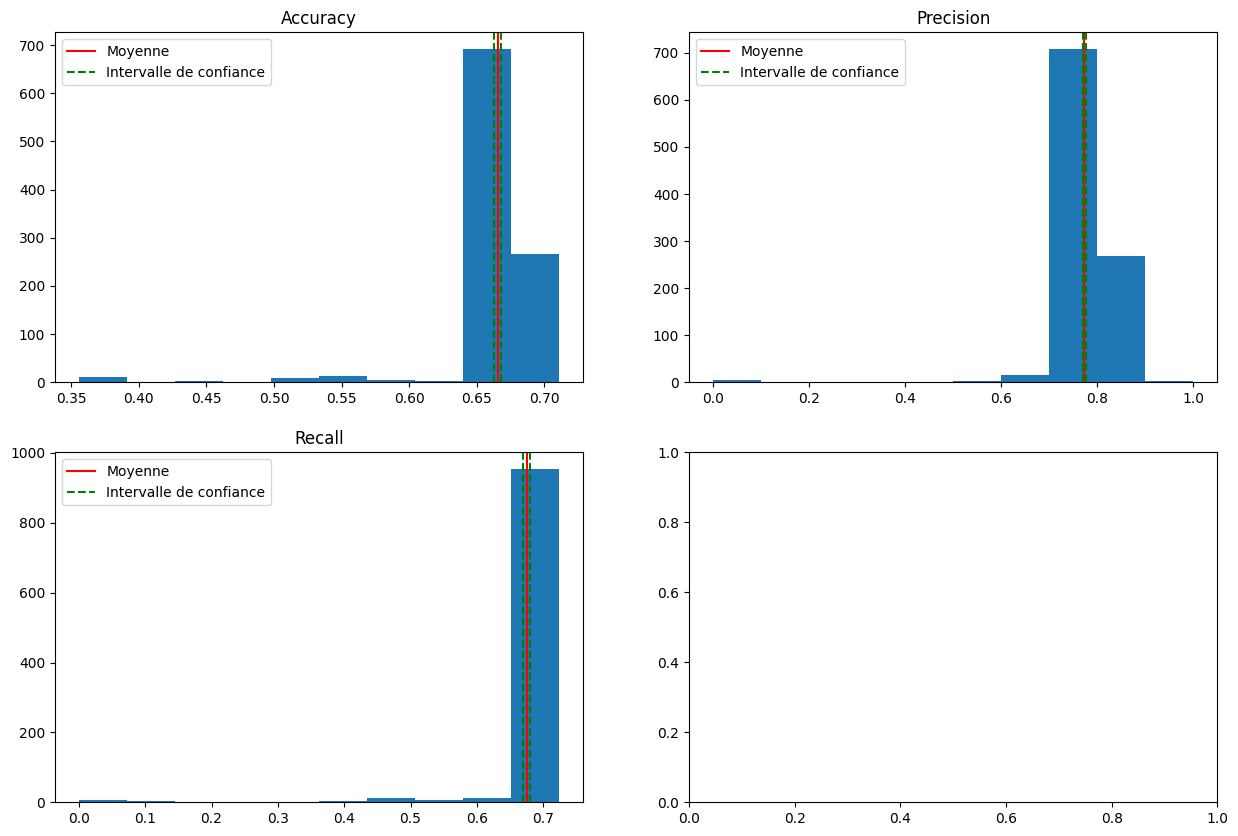

In [39]:
from scipy import stats
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()

# métriques +scores
metrics = ['Accuracy', 'Precision', 'Recall']
scores = [accuracy_scores, precision_scores, recall_scores]

for i in range(len(metrics)):
    # calculer l'intervalle de confiance à 95 % pour chaque métrique
    conf_interval = stats.t.interval(0.95, len(scores[i])-1, loc=np.mean(scores[i]), scale=stats.sem(scores[i]))
    
    # tracer l'histogramme avec l'intervalle de confiance
    axs[i].hist(scores[i], bins=10)
    axs[i].axvline(np.mean(scores[i]), color='red', label='Moyenne')
    axs[i].axvline(conf_interval[0], color='green', linestyle='--', label='Intervalle de confiance')
    axs[i].axvline(conf_interval[1], color='green', linestyle='--')
    axs[i].set_title(metrics[i])
    axs[i].legend()

# afficher le graphique
plt.show()